In [2]:
import os
import time
import warnings
import ast
from collections import Counter
from datetime import datetime

import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException, TimeoutException, ElementClickInterceptedException
from webdriver_manager.chrome import ChromeDriverManager


# 한글폰트 설치

In [3]:
# 나눔바른고딕 글꼴 파일 경로 지정
current_directory = "/content/drive/MyDrive/Colab Notebooks"
font_path = os.path.join(current_directory, "NanumBarunGothic.ttf")

#글꼴이 있는지 확인
if os.path.exists(font_path):
    #폰트 추가
    fm.fontManager.addfont(font_path)

    # 캐시를 새로 고치지 않고 직접 폰트 설정
    font_prop = fm.FontProperties(fname=font_path)
    plt.rc("font", family=font_prop.get_name())
    plt.rcParams["axes.unicode_minus"] = False # 마이너스 부호 출력 설정

In [4]:
# 현재 작업 디렉토리 경로 얻기
current_directory = os.getcwd()
# 나눔바른고딕 글꼴 파일 경로 지정
font_path = os.path.join(current_directory, "NanumBarunGothic.ttf")

# 글꼴이 있는지 확인
if os.path.exists(font_path):
    # 폰트 추가
    fm.fontManager.addfont(font_path)

    # 캐시를 새로 고치지 않고 직접 폰트 설정
    font_prop = fm.FontProperties(fname=font_path)
    plt.rc("font", family=font_prop.get_name())
    plt.rcParams["axes.unicode_minus"] = False  # 마이너스 부호 출력 설정

# 1. 데이터 불러오기 및 데이터 확인

In [5]:
# Yes24 Dataset
yes_df = pd.read_csv('D:\workspace\M3_분석라이브러리\yes24_bestseller_data_final.csv')
yes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13620 entries, 0 to 13619
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Year          13620 non-null  int64  
 1   Month         13620 non-null  int64  
 2   Category      13620 non-null  object 
 3   Title         13620 non-null  object 
 4   Author        13620 non-null  object 
 5   Publisher     13620 non-null  object 
 6   Price         13620 non-null  int64  
 7   Publish_Date  13620 non-null  object 
 8   Sales_Index   13620 non-null  int64  
 9   Rating        13620 non-null  float64
 10  Age_Scores    13620 non-null  object 
 11  Pages         13572 non-null  object 
 12  Keywords      13620 non-null  object 
 13  Gender        13620 non-null  int64  
 14  Age           13620 non-null  int64  
 15  month         13620 non-null  int64  
dtypes: float64(1), int64(7), object(8)
memory usage: 1.7+ MB


In [65]:
# 인터파크 Dataset
ip_df = pd.read_csv('D:\workspace\M3_분석라이브러리\Interpark_books_dataset.csv')
ip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23899 entries, 0 to 23898
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Publisher  23899 non-null  object
 1   Category   23899 non-null  object
 2   Title      23899 non-null  object
 3   Sales      23899 non-null  object
 4   Year       23899 non-null  int64 
 5   Month      23899 non-null  int64 
 6   Age        23899 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 1.3+ MB


# 전처리

In [6]:
# 결측치 평균값 채우기
yes_df['Pages'] = pd.to_numeric(yes_df['Pages'], errors='coerce')
mean_pages = yes_df['Pages'].mean()  # 평균값 계산

# 결측치를 평균값으로 채우기
yes_df['Pages'].fillna(mean_pages, inplace=True)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6040\1002275636.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  yes_df['Pages'].fillna(mean_pages, inplace=True)


In [33]:
missing_values = yes_df.isnull().sum()
print(missing_values)

Year            0
Month           0
Category        0
Title           0
Author          0
Publisher       0
Price           0
Publish_Date    0
Sales_Index     0
Rating          0
Age_Scores      0
Pages           0
Keywords        0
Gender          0
Age             0
month           0
dtype: int64


In [65]:
# 가격 범주화
price_bins = [0, 10000, 15000, 20000, 30000, float('inf')]
price_labels = ['저가', '중저가', '중가', '고가', '최고가']
yes_df['Price_Range'] = pd.cut(yes_df['Price'], bins=price_bins, labels=price_labels, include_lowest=True)

# 페이지 범주화
page_bins = [0, 100, 200, 300, 500, float('inf')]
page_labels = ['동화', '단편', '중편', '장편', '초장편']
yes_df['page_labels'] = pd.cut(yes_df['Pages'], bins=page_bins, labels=page_labels, include_lowest=True)

# 새로운 칼럼 생성 (출판월)
def get_month(publish_date):
    return int(publish_date.split(' ')[1][:-1])

# 월 추출
yes_df['publish_month'] = yes_df['Publish_Date'].apply(get_month)

gender_mapping = {0: '남자', 1: '여자'}
yes_df['Gender'] = yes_df['Gender'].map(gender_mapping)

In [81]:
yes_df['Age'].unique()

array([10, 20, 30, 40, 50, 60])

In [85]:
# 핫키워드 top3 추천. (카테고리, 성별)
from collections import Counter
import ast

def get_top_keywords(yes_df, target, top_n=3):
    # 입력 필터링
    # filtered_df = yes_df[yes_df['Category'] == target]
    filtered_df = yes_df[yes_df['Gender'] == target] # 매핑했으면 남자,여자, 안했으면 0,1
    
    # 카운터 초기화
    counter = Counter()

    for keywords in filtered_df['Keywords']:
        keywords_list = ast.literal_eval(keywords)
        counter.update(keywords_list)

    # 정렬 후 상위 n개 추출
    top_keywords = counter.most_common(top_n)

    return top_keywords

# 키워드 입력 받기
target = input("대상을 입력하세요: ")

# 상위 3개 키워드 추출
top_3_keywords = get_top_keywords(yes_df, target, top_n=3)

# 결과 출력
for keyword, count in top_3_keywords:
    print(f'{keyword}: {count}')


#크레마클럽에있어요: 906
#이달의굿즈: 804
#얼리리더: 606


In [73]:
def get_top_keywords(yes_df, category_name=None, age_range=None, gender=None, top_n=3):
    # 필터링 조건 설정
    if category_name:
        yes_df = yes_df[yes_df['Category'] == category_name]
    if age_range:
        yes_df = yes_df[yes_df['Age_Range'] == age_range]
    if gender:
        yes_df = yes_df[yes_df['Gender'] == gender]

    # 카운터 초기화
    counter = Counter()

    for keywords in yes_df['Keywords']:
        keywords_list = ast.literal_eval(keywords)
        counter.update(keywords_list)

    # 정렬 후 상위 n개 추출
    top_keywords = counter.most_common(top_n)

    return top_keywords

# 키워드 입력 받기
category_name = input("카테고리를 입력하세요 (없으면 Enter): ").strip() or None
age_range = input("연령대를 입력하세요 (없으면 Enter): ").strip() or None
gender = input("성별을 입력하세요 (남자/여자, 없으면 Enter): ").strip() or None

# 상위 3개 키워드 추출
top_3_keywords = get_top_keywords(yes_df, category_name, age_range, gender, top_n=3)

# 결과 출력
for keyword, count in top_3_keywords:
    print(f'{keyword}: {count}')


KeyError: 'Age_Range'

# 1. 연령대 별

총 3개 그래프 출력
- subplot(3x2)
- pie (size 조금 크게 ?)
- subplot(3x2)

In [64]:
yes_df.head()

,Year,Month,Category,Title,Author,Publisher,Price,Publish_Date,Sales_Index,Rating,Age_Scores,Pages,Keywords,Gender,Age,month,Price_Range,page_labels,publish_month
0,2024,1,가정과 살림,나는 다정한 관찰자가 되기로 했다,이은경 저,서교책방,16020,2024년 05월,237453,9.7,"{'10대': 0.0, '20대': 10.0, '30대': 9.0, '40대': 9...",288.000000,"['#엄마가된다는것', '#엄마는처음이라', '#초보엄마', '#자녀교육']",1,10,6,중가,중편,5
1,2024,1,가정과 살림,성심당 케이크 레시피,안종섭 저,비앤씨월드,18000,2024년 05월,3060,9.1,{},228.000000,"['#레시피', '#맛집레시피', '#디저트레시피북', '#베이킹', '#홈베이킹']",1,10,6,중가,중편,5
2,2024,1,가정과 살림,조이 오브 쿠킹,"이르마 S. 롬바우어, 존 베커, 메건 스콧 저/구계원 역",세미콜론,69300,2024년 02월,2076,9.8,{},317.436444,"['#도시락레시피', '#반찬고민', '#간편요리', '#자취요리', '#집반찬']",1,10,6,최고가,장편,2
3,2024,1,가정과 살림,10분 완성 초간단 도시락 레시피 100,오민주 저,시원북스,16020,2024년 02월,7914,9.9,"{'10대': 0.0, '20대': 0.0, '30대': 10.0, '40대': 9...",260.000000,"['#크레마클럽에있어요', '#새해결심', '#집밥레시피', '#자취요리', '#싸...",1,10,6,중가,중편,2
4,2024,1,가정과 살림,뿐이 토핑 이유식,정주희 저/이수진 감수,서사원,26820,2024년 03월,89208,9.8,"{'10대': 0.0, '20대': 0.0, '30대': 9.0, '40대': 10...",640.000000,"['#국민육아템', '#초보엄마', '#간편이유식']",1,20,6,고가,초장편,3


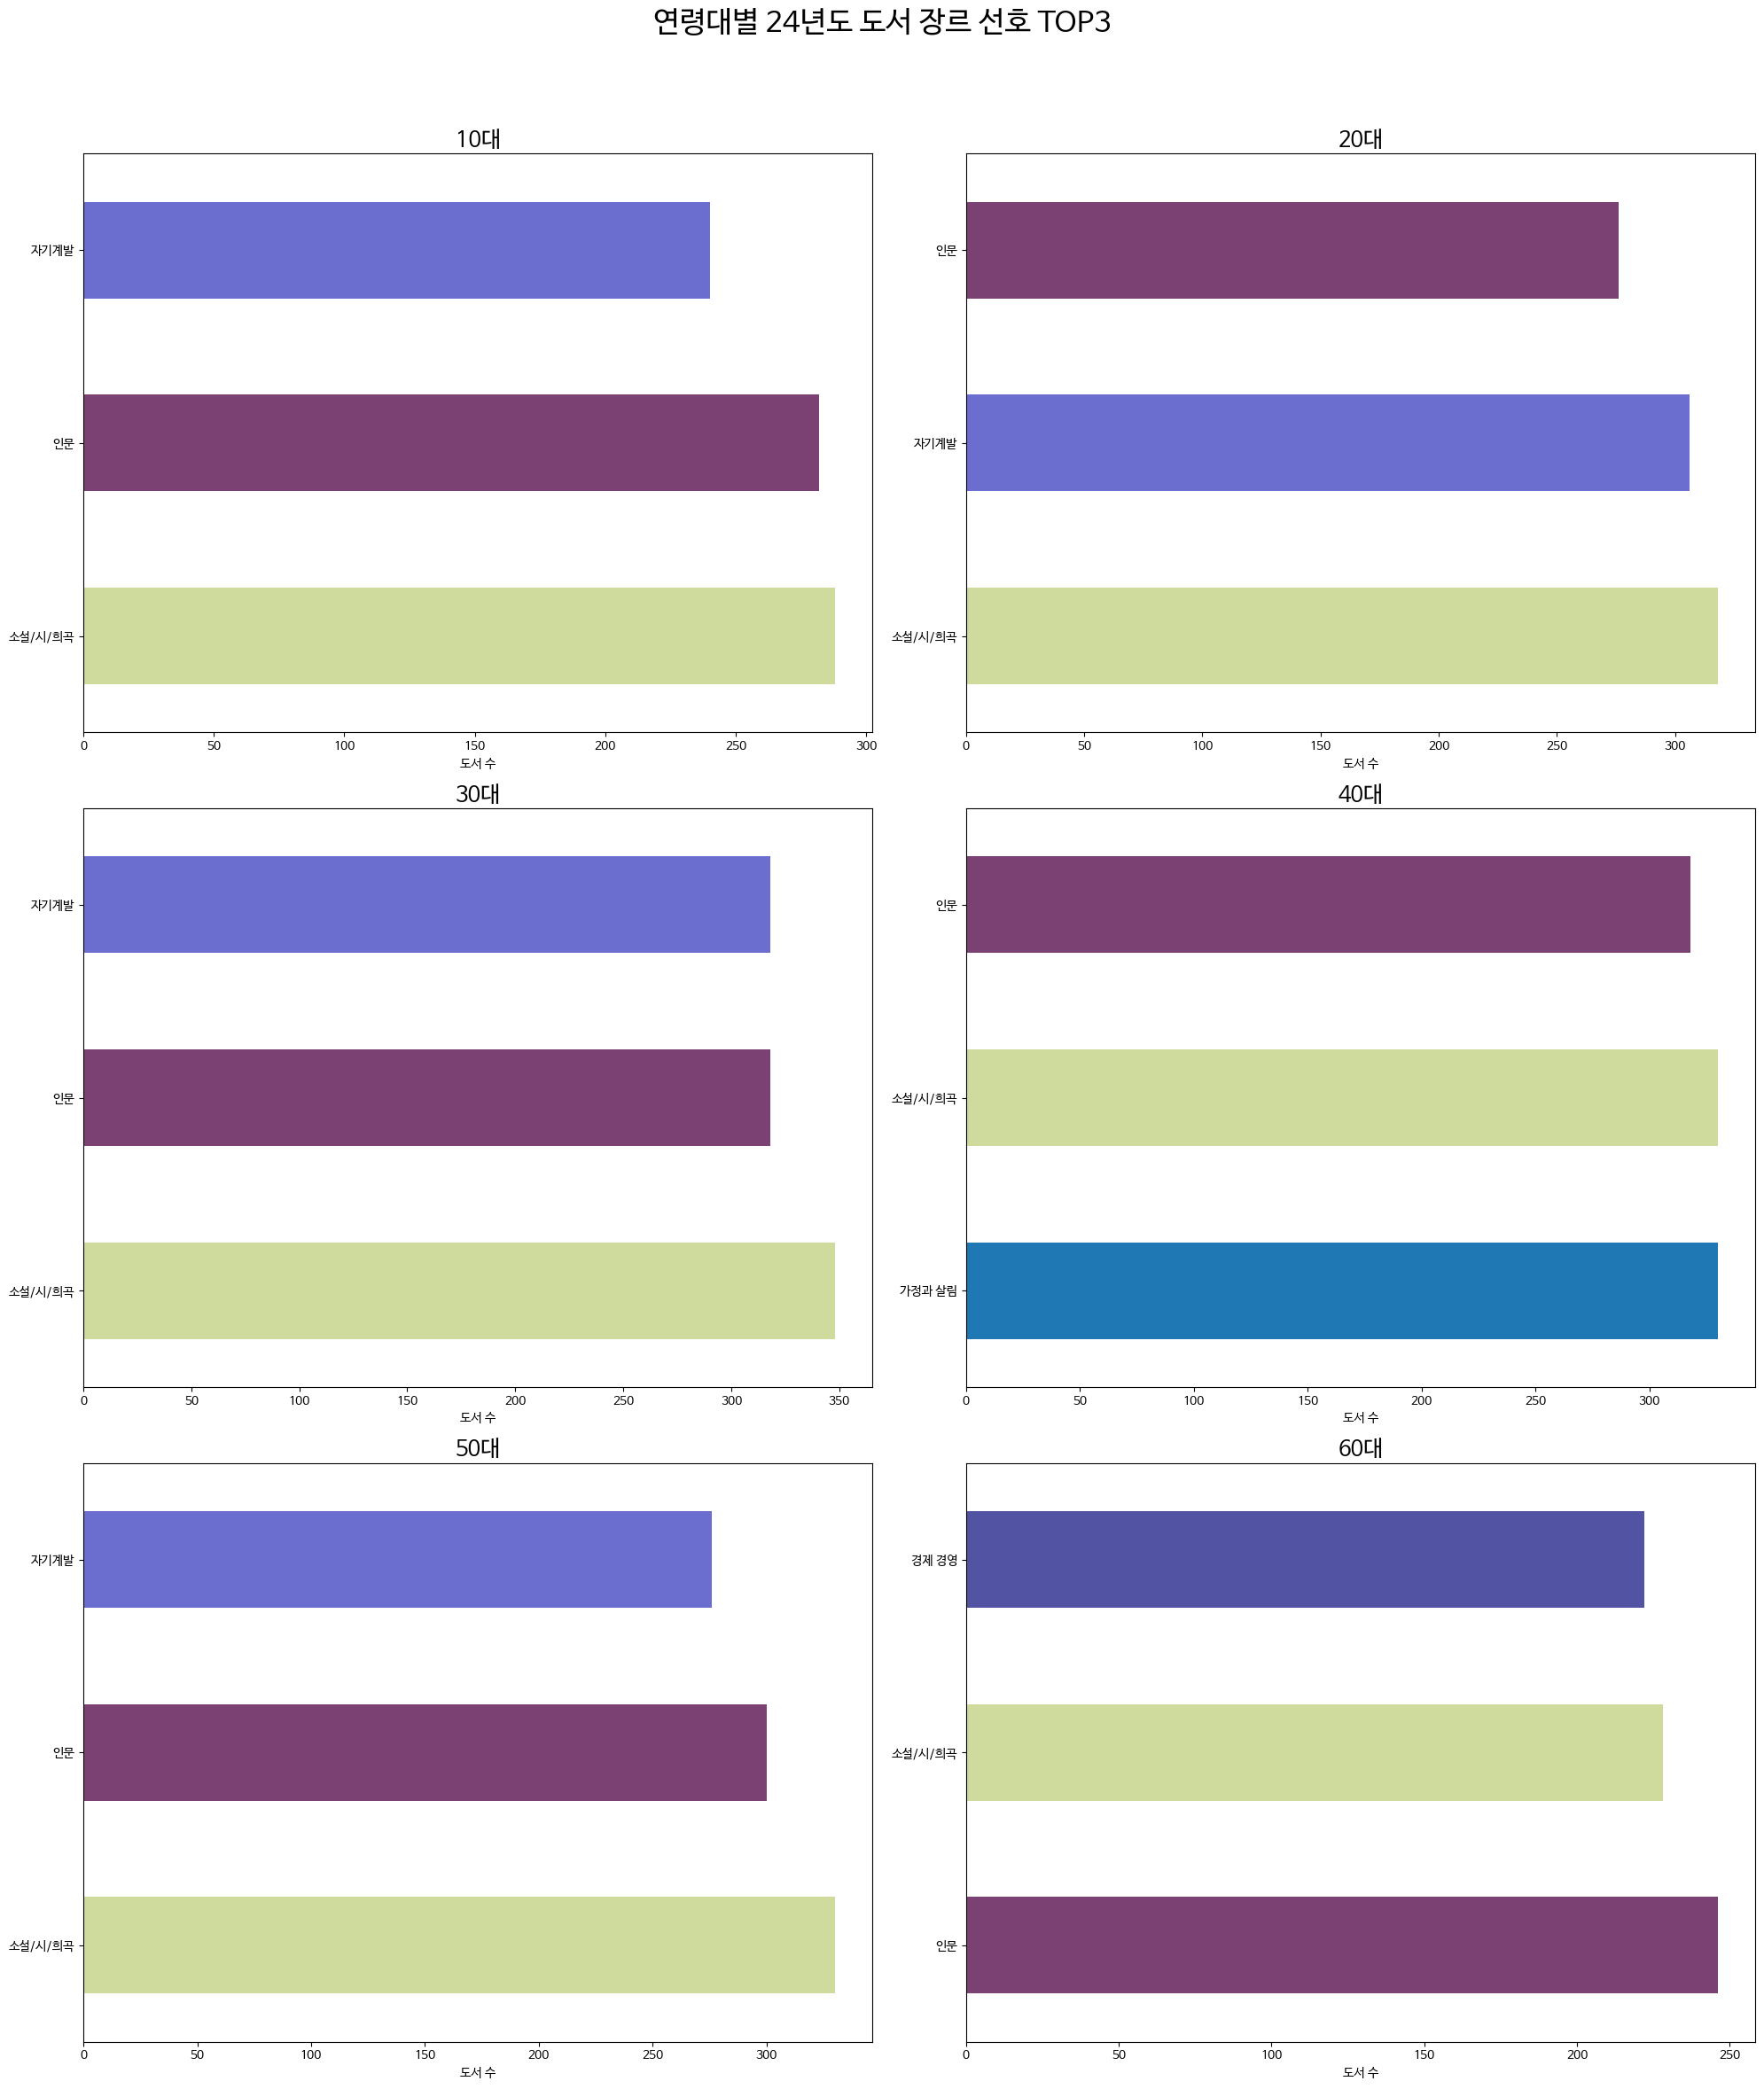

In [27]:
# 24년도 10, 20, 30, 40, 50, 60 카테고리 TOP3 (kind='barh')   ## 3행 2열

age_groups = yes_df['Age'].unique()

custom_colors = [
    '#1f77b4',# '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
    '#D500B7', '#bcbd22', '#17becf', '#393b79', #'#637939', '#8c6d31', '#843c39',
    '#7b4173', '#5254a3', '#6b6ecf', '#9c9ede', '#cedb9c', '#e7ba52'
]
# 모든 카테고리 추출 및 색상 맵 생성
all_categories = yes_df['Category'].unique()
color_map = dict(zip(all_categories, custom_colors[:len(all_categories)]))

fig, axes = plt.subplots(3, 2, figsize=(20, 24))

for i, age_label in enumerate(age_groups):
    row, col = divmod(i, 2)

    # 해당 연령대의 카테고리 선호도 계산
    preferences = yes_df[(yes_df['Age'] == age_label) & (yes_df['Year'] == 2024)]['Category'].value_counts().nlargest(3)

    # 색상 리스트 생성
    colors = [color_map.get(cat, '#808080') for cat in preferences.index]

    # 막대 그래프 그리기
    preferences.plot(kind='barh', ax=axes[row, col], color=colors)
    
    axes[row, col].set_title(f'{age_label}대', size=18)
    axes[row, col].set_xlabel('도서 수')
    axes[row, col].set_ylabel('')

plt.suptitle('연령대별 24년도 도서 장르 선호 TOP3', size=24)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

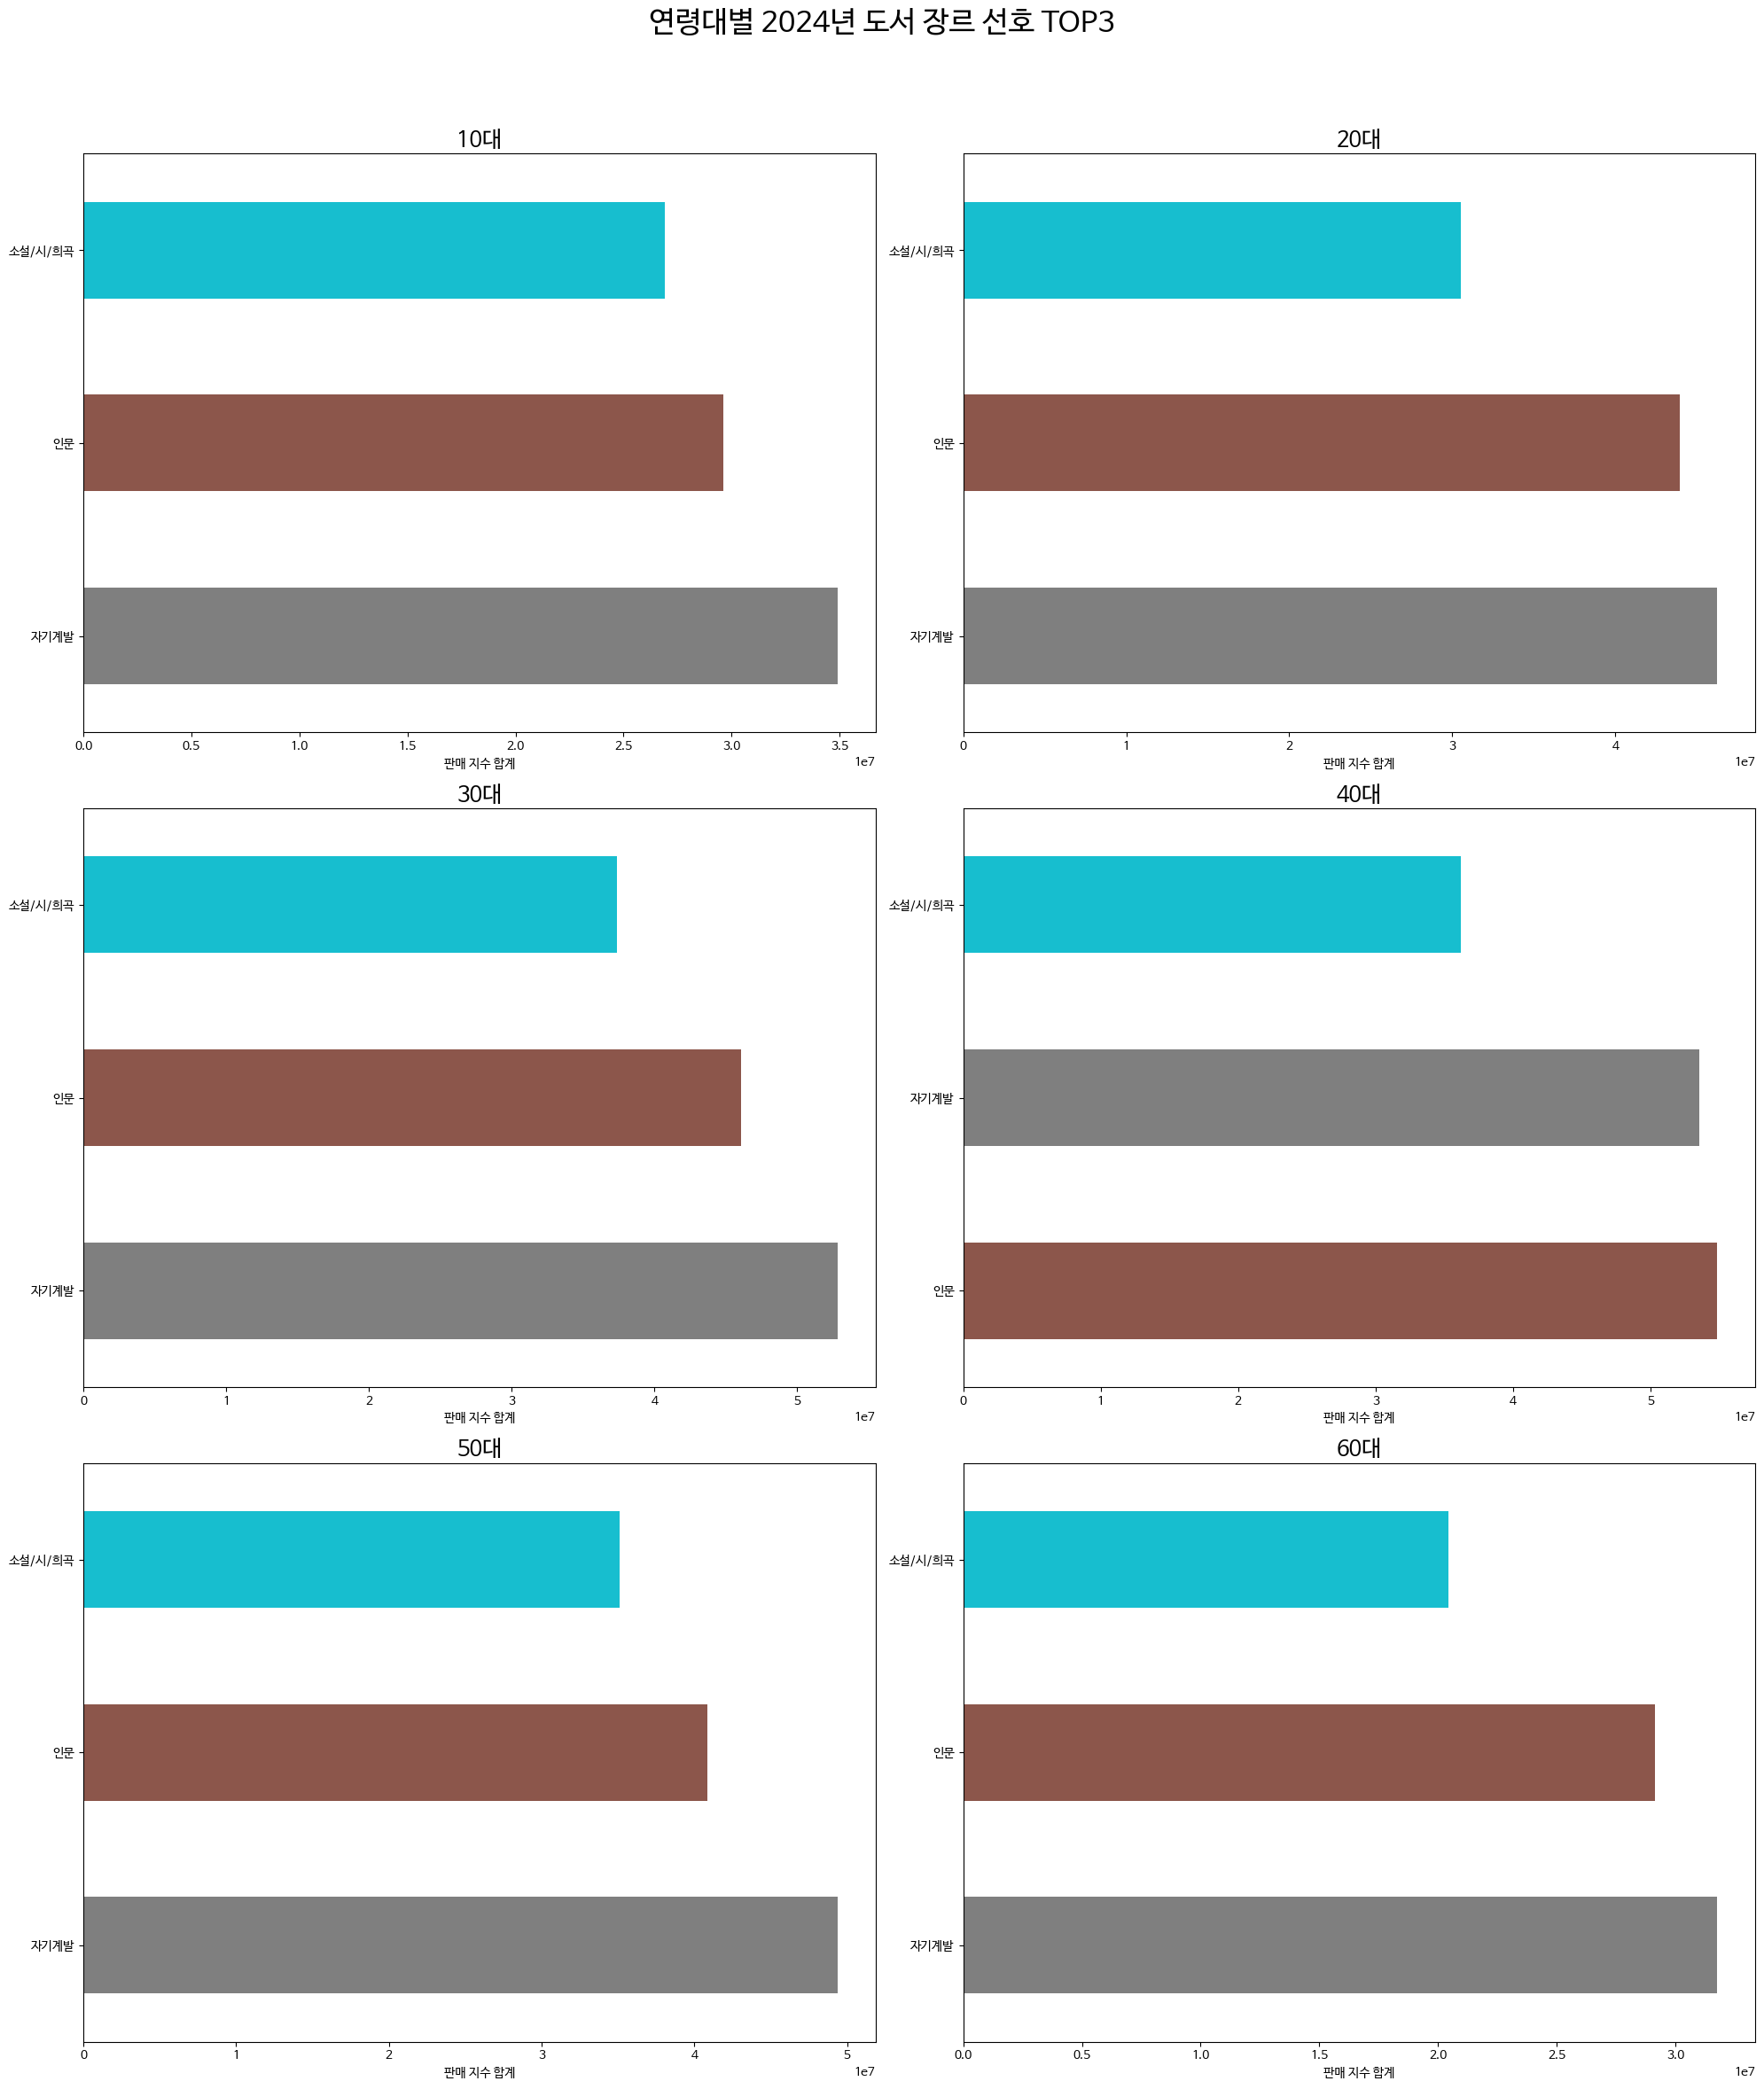

In [195]:
import matplotlib.pyplot as plt

age_groups = yes_df['Age'].unique()

# 사용할 색상 정의
custom_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                 '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# 모든 카테고리 추출 및 색상 맵 생성
all_categories = yes_df['Category'].unique()
color_map = dict(zip(all_categories, custom_colors[:len(all_categories)]))


fig, axes = plt.subplots(3, 2, figsize=(20, 24))

# 각 연령대별로 그래프 생성
for i, age_label in enumerate(age_groups):
    row, col = divmod(i, 2)

    preferences = yes_df[(yes_df['Age'] == age_label) & (yes_df['Year'] == 2024)].groupby('Category')['Sales_Index'].sum().nlargest(3)
    colors = [color_map.get(cat, '#808080') for cat in preferences.index]

    # 막대 그래프 그리기
    preferences.plot(kind='barh', ax=axes[row, col], color=colors)    
    axes[row, col].set_title(f'{age_label}대', size=18)
    axes[row, col].set_xlabel('판매 지수 합계')
    axes[row, col].set_ylabel('')

plt.suptitle('연령대별 2024년 도서 장르 선호 TOP3', size=24)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


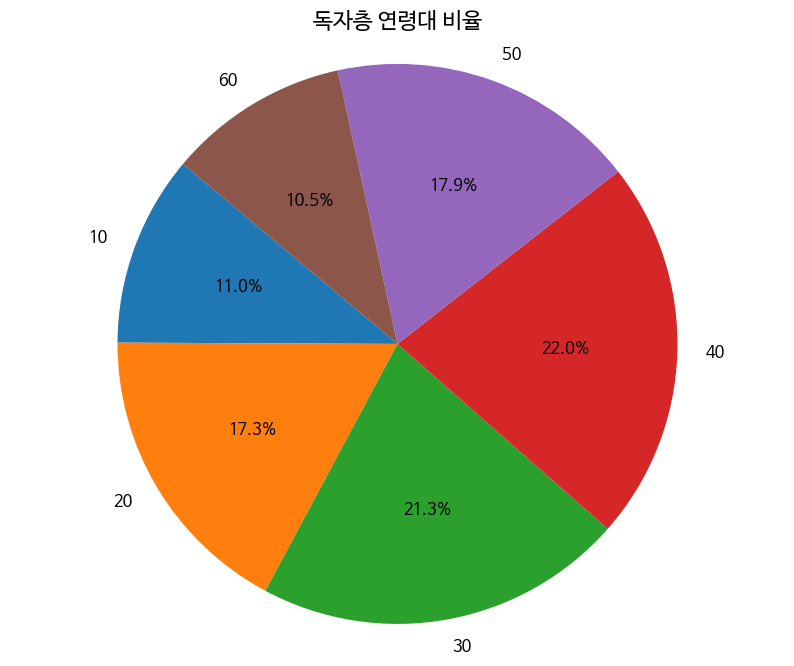

In [199]:
# 독자 연령대 비율 groupby('Age')['Sales_Index'].sum()        ## pie chart

age_sales = yes_df.groupby('Age')['Sales_Index'].sum()

# 파이 차트 그리기
plt.figure(figsize=(10, 8))
wedges, texts, autotexts = plt.pie(age_sales, labels=age_sales.index, autopct='%1.1f%%', startangle=140)

# 차트 스타일링
plt.setp(texts, size=12, weight='bold')
plt.setp(autotexts, size=12, weight='bold')

plt.title('독자층 연령대 비율', size=16)
plt.axis('equal')  # 원형을 유지하기 위해 가로세로 비율을 동일하게 설정

plt.show()

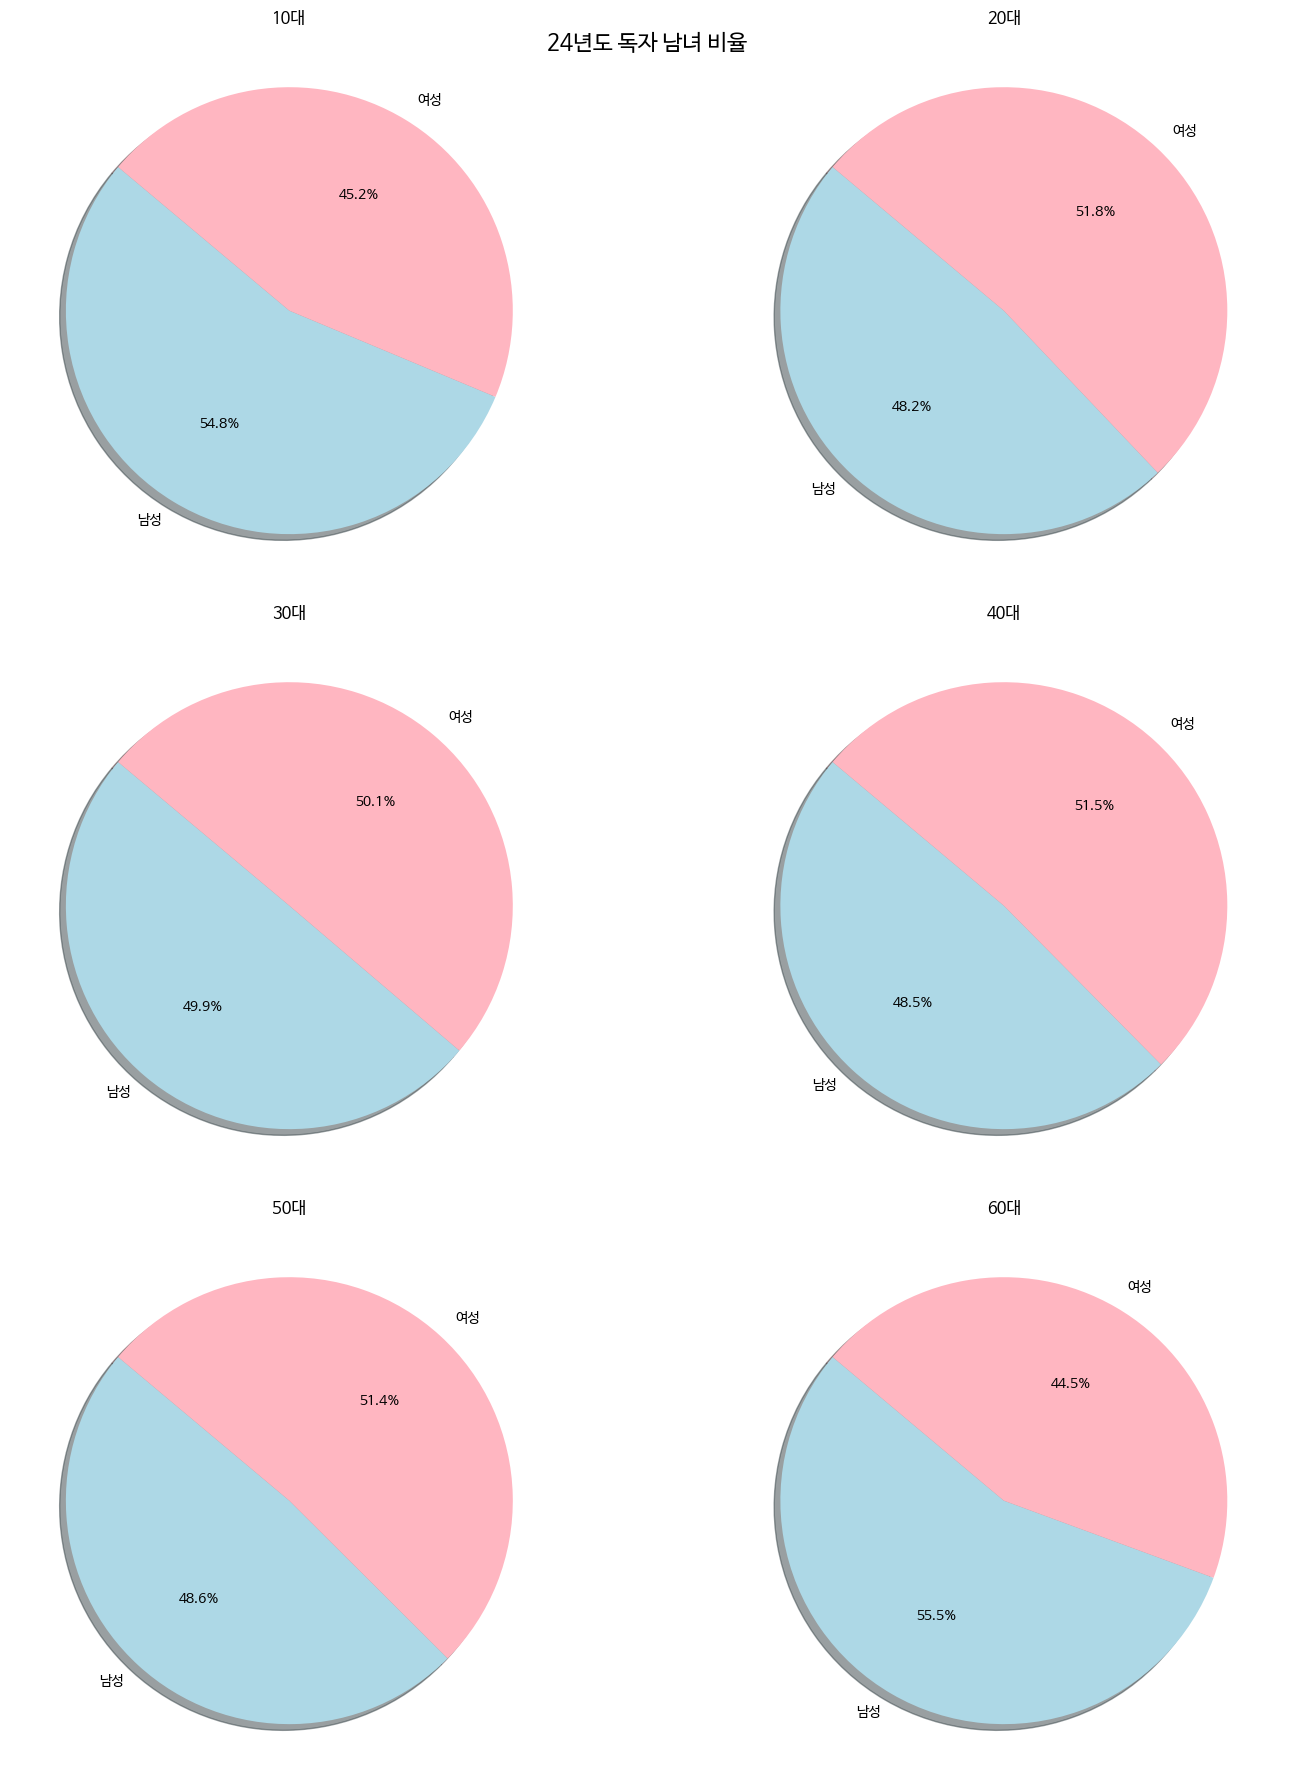

In [20]:
# 24년도 10, 20, 30, 40, 50, 60 독자 남녀 비율 groupby(['Age', 'Gender'])['Sales_Index'].sum()    ## subplot piechart (x6) 3행 2열

sales_summary = yes_df.groupby(['Age', 'Gender'])['Sales_Index'].sum().unstack()

# 결과 시각화
fig, axes = plt.subplots(3, 2, figsize=(16, 18)) 

colors = ['lightblue', 'lightpink']

for ax, (age, row) in zip(axes.flatten(), sales_summary.iterrows()):
    pie = row.plot(kind='pie', ax=ax, labels=['남성', '여성'], autopct='%1.1f%%', startangle=140, colors=colors, shadow=True)
    ax.set_title(f'{age}대')
    ax.set_ylabel('') 
    ax.set_aspect('equal')

plt.tight_layout()
plt.suptitle('24년도 독자 남녀 비율', fontsize=16)
plt.show()


# 2. 카테고리 별

총 3개 그래프 출력
- subplot(3x1)
- barh
- 꺾은선 그래프(size 너무크지 않게)

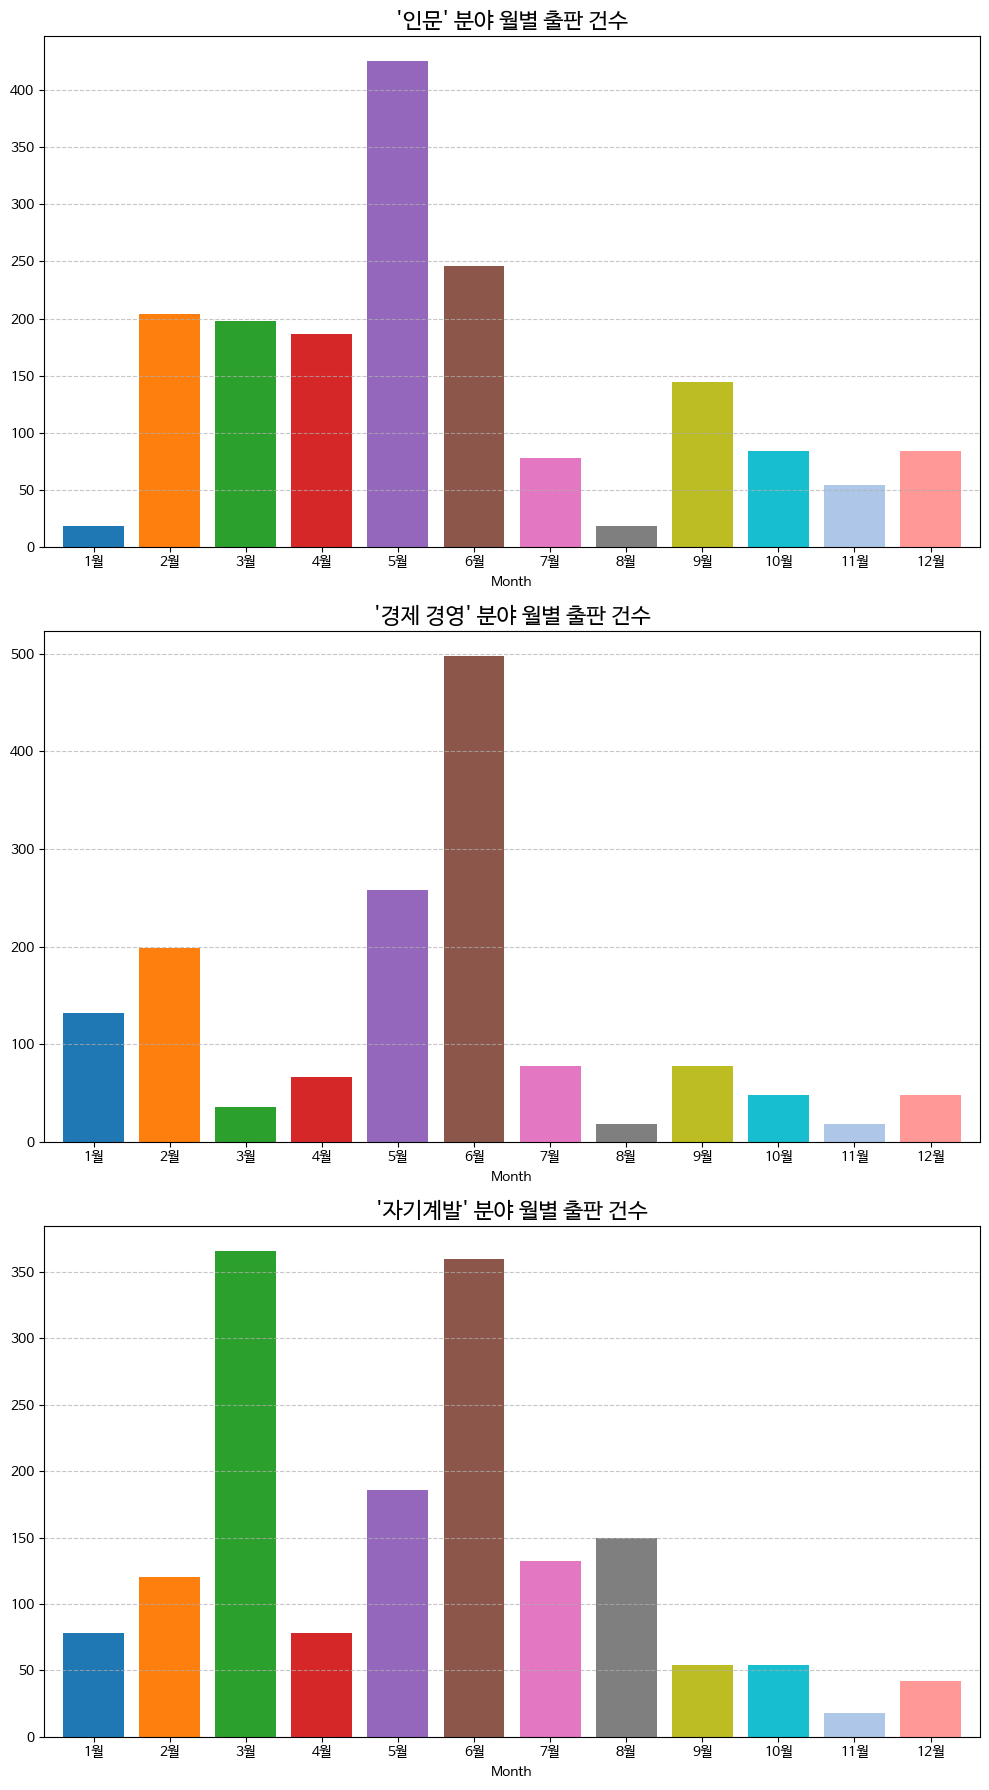

In [187]:
month_category_counts = yes_df.groupby(['publish_month', 'Category']).size().unstack().fillna(0)

# 선택한 카테고리 리스트
selected_categories = ['인문', '경제 경영', '자기계발']

# 각 카테고리별로 월별 카운트 데이터 추출
category_data = {}
for category in selected_categories:
    if category in month_category_counts.columns:
        category_data[category] = month_category_counts[category]


custom_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8', '#ff9896']


# 막대 그래프로 시각화
fig, axes = plt.subplots(len(selected_categories), 1, figsize=(10, 18))

for i, category in enumerate(selected_categories):
    ax = axes[i]
    if category in category_data:
        month_counts = category_data[category]
        month_counts.plot(kind='bar', ax=ax, color=custom_colors, width=0.8)
        ax.set_title(f"'{category}' 분야 월별 출판 건수", size=16)
        ax.set_xlabel('Month')
        ax.set_ylabel('')
        ax.set_xticklabels([f'{m}월' for m in month_counts.index], rotation=0)
        ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

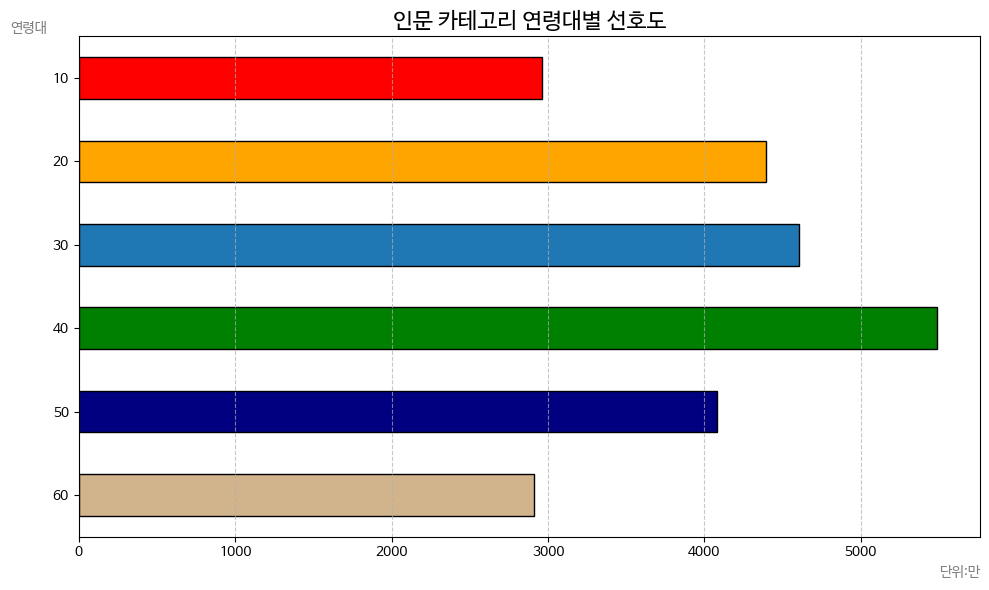

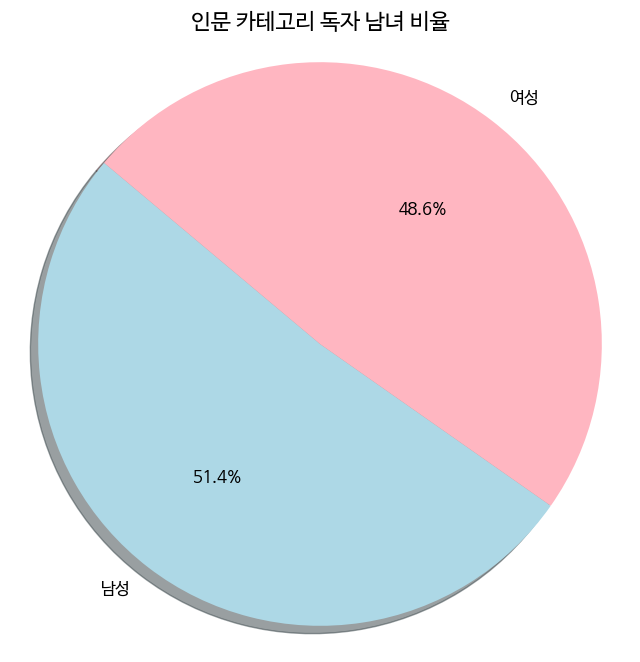

In [162]:
# 인문 카테고리 연령대별 선호도 (kind='barh'),  인문 카테고리 독자 남녀 비율

humanities_data = yes_df[yes_df['Category'] == '인문']

custom_colors = ['#FF0000', '#FFA500', '#1f77b4', '#008000', '#000080', '#D2B48C']

# 인문 카테고리 연령대별 선호도 막대 그래프

age_sales = humanities_data.groupby('Age')['Sales_Index'].sum() / 10000  # 판매 지수를 '만' 단위로 변환

plt.figure(figsize=(10, 6))
age_sales.plot(kind='barh', color=custom_colors, edgecolor='black')
plt.title('인문 카테고리 연령대별 선호도', size=16)
plt.xlabel('단위:만', loc='right', color='gray')
plt.ylabel('연령대', rotation=0, loc='top', color='gray')
plt.gca().invert_yaxis()  
plt.grid(axis='x', linestyle='--', alpha=0.7) 
plt.tight_layout()
plt.show()

# 인문 카테고리 독자 남녀 비율 파이 차트
gender_ratio = humanities_data['Gender'].value_counts()

plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(gender_ratio, labels=['남성', '여성'], autopct='%1.1f%%', startangle=140, colors=['lightblue', 'lightpink'], shadow=True)
plt.setp(texts, size=12, weight='bold')
plt.setp(autotexts, size=12, weight='bold')
plt.title('인문 카테고리 독자 남녀 비율', size=16)
plt.axis('equal')
plt.show()


# 3. 성별 별

총 2개 그래프 출력
- 수평 막대 그래프 (x: [10m, 20m, 30m, 40m, 50m, 60m]
- 수평 막대 그래프 (x: ['가정살림', '경제경영', ...]

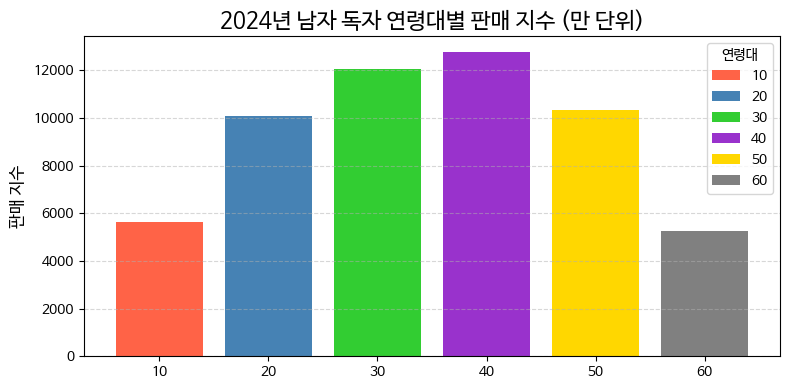

In [208]:
# 24년도 남자 독자 연령대 분포도 df[df['Gender']=='M'].groupby('Age')['Sales_Index'].sum() ( 막대 그래프 )

male_sales_by_age = yes_df[yes_df['Gender'] == 1].groupby('Age')['Sales_Index'].sum() / 10000  # 판매 지수를 '만' 단위로 변환

# 연령대에 따른 색상 맵
custom_colors = ['#FF6347', '#4682B4', '#32CD32', '#9932CC', '#FFD700', '#808080']

# 막대 그래프 생성
plt.figure(figsize=(8, 4))
bars = plt.bar(male_sales_by_age.index.astype(str), male_sales_by_age, color=custom_colors)

plt.title('2024년 남자 독자 연령대별 판매 지수 (만 단위)', fontsize=16)
plt.xlabel('')
plt.ylabel('판매 지수', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.legend(bars, male_sales_by_age.index.astype(str), title='연령대', title_fontsize=10, loc='upper right', fontsize=10)
plt.grid(axis='y',linestyle='--',alpha=0.5)
plt.tight_layout()
plt.show()

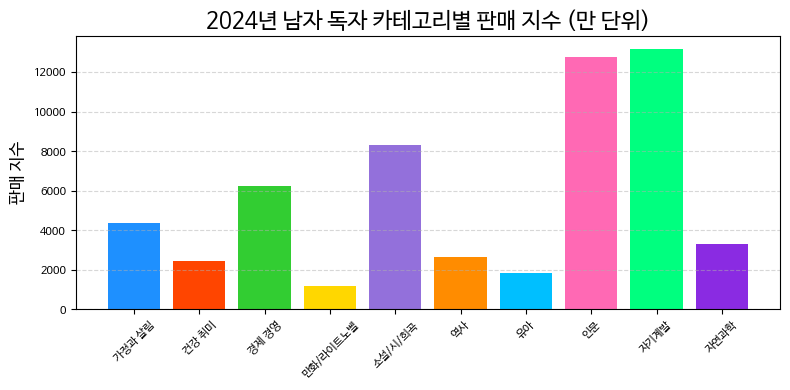

In [8]:
# 24년도 남자 독자 카테고리 선호도 ( 10개 카테고리 막대그래프 sort할 필요 x )  ( 막대 그래프 )

male_sales_by_age = yes_df[yes_df['Gender'] == 1].groupby('Category')['Sales_Index'].sum() / 10000  # 판매 지수를 '만' 단위로 변환

custom_colors = ['#1E90FF', '#FF4500', '#32CD32', '#FFD700', '#9370DB', '#FF8C00', '#00BFFF', '#FF69B4', '#00FF7F', '#8A2BE2']

# 막대 그래프 생성
plt.figure(figsize=(8, 4))
bars = plt.bar(male_sales_by_age.index.astype(str), male_sales_by_age, color=custom_colors)

plt.title('2024년 남자 독자 카테고리별 판매 지수 (만 단위)', fontsize=16)
plt.xlabel('')
plt.ylabel('판매 지수', fontsize=12)
plt.xticks(fontsize=8, rotation=45)
plt.yticks(fontsize=8)

# plt.legend(bars, male_sales_by_age.index.astype(str), title='연령대', title_fontsize=10, loc='upper right', fontsize=10)
plt.grid(axis='y',linestyle='--',alpha=0.5)
plt.tight_layout()
plt.show()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6040\4008969120.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_range_by_gender = yes_df.groupby(['Gender', 'Price_Range']).size().reset_index(name='Count')


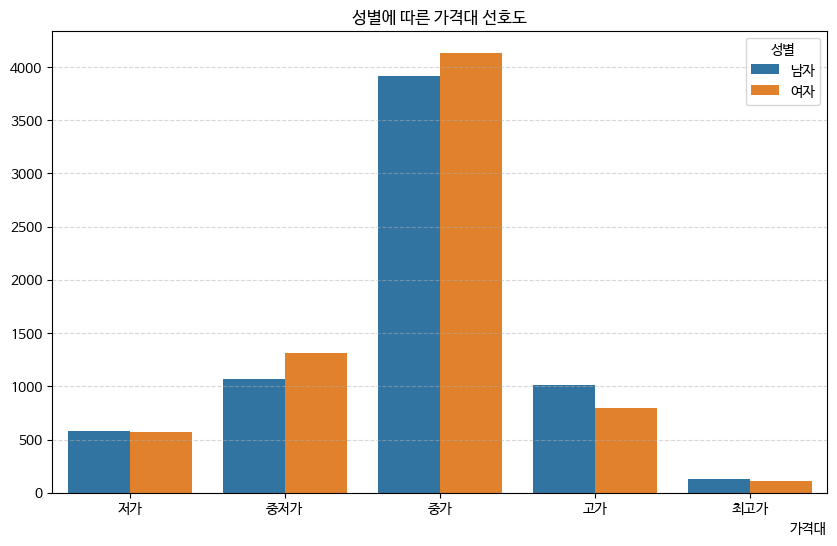

In [66]:
# 성별에 따른 책구매가격 선호도
price_range_by_gender = yes_df.groupby(['Gender', 'Price_Range']).size().reset_index(name='Count')

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=price_range_by_gender, x='Price_Range', y='Count', hue='Gender')
plt.title('성별에 따른 가격대 선호도')
plt.xlabel('가격대', loc='right')
plt.ylabel('')
plt.legend(title='성별')
plt.grid(axis='y', linestyle='--', alpha=0.5) 
plt.show()

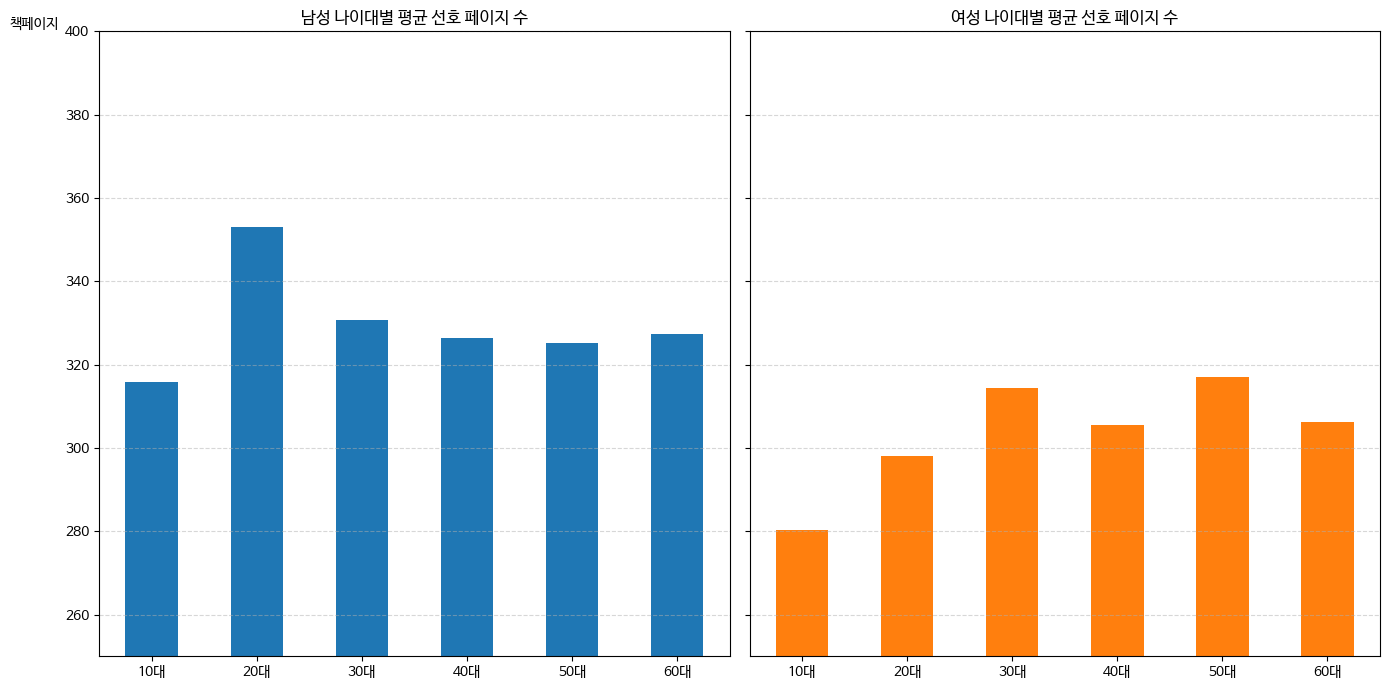

In [48]:
# 성별&연령대별 책두께 선호도
gender_age_page_mean = yes_df.groupby(['Gender', 'Age'])['Pages'].mean().unstack()

# 바차트 그리기
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7), sharey=True)

# 성별 레이블 설정
gender_labels = {0: '남', 1: '여'}

# 각 성별에 맞는 색상 설정
custom_colors = ['#1f77b4', '#ff7f0e']  # 남성: 파란색, 여성: 주황색

for i, (gender, color) in enumerate(zip(gender_age_page_mean.index, custom_colors)):
    ax = gender_age_page_mean.loc[gender].plot(kind='bar', ax=axes[i], color=color)
    ax.set_title(f'{gender_labels[gender]}성 나이대별 평균 선호 페이지 수')
    ax.set_xlabel('')
    ax.set_ylabel('책페이지', loc='top',rotation=0)
    ax.set_ylim(250, 400)  # y축 범위 설정
    ax.set_xticklabels(['10대', '20대', '30대', '40대', '50대', '60대'], rotation=0)
    ax.grid(axis='y', linestyle='--', alpha=0.5)  # y축 그리드 선 추가

plt.tight_layout()
plt.show()


In [34]:
yes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13620 entries, 0 to 13619
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Year           13620 non-null  int64   
 1   Month          13620 non-null  int64   
 2   Category       13620 non-null  object  
 3   Title          13620 non-null  object  
 4   Author         13620 non-null  object  
 5   Publisher      13620 non-null  object  
 6   Price          13620 non-null  int64   
 7   Publish_Date   13620 non-null  object  
 8   Sales_Index    13620 non-null  int64   
 9   Rating         13620 non-null  float64 
 10  Age_Scores     13620 non-null  object  
 11  Pages          13620 non-null  float64 
 12  Keywords       13620 non-null  object  
 13  Gender         13620 non-null  int64   
 14  Age            13620 non-null  int64   
 15  month          13620 non-null  int64   
 16  Price_Range    13620 non-null  category
 17  page_labels    13620 non-null  

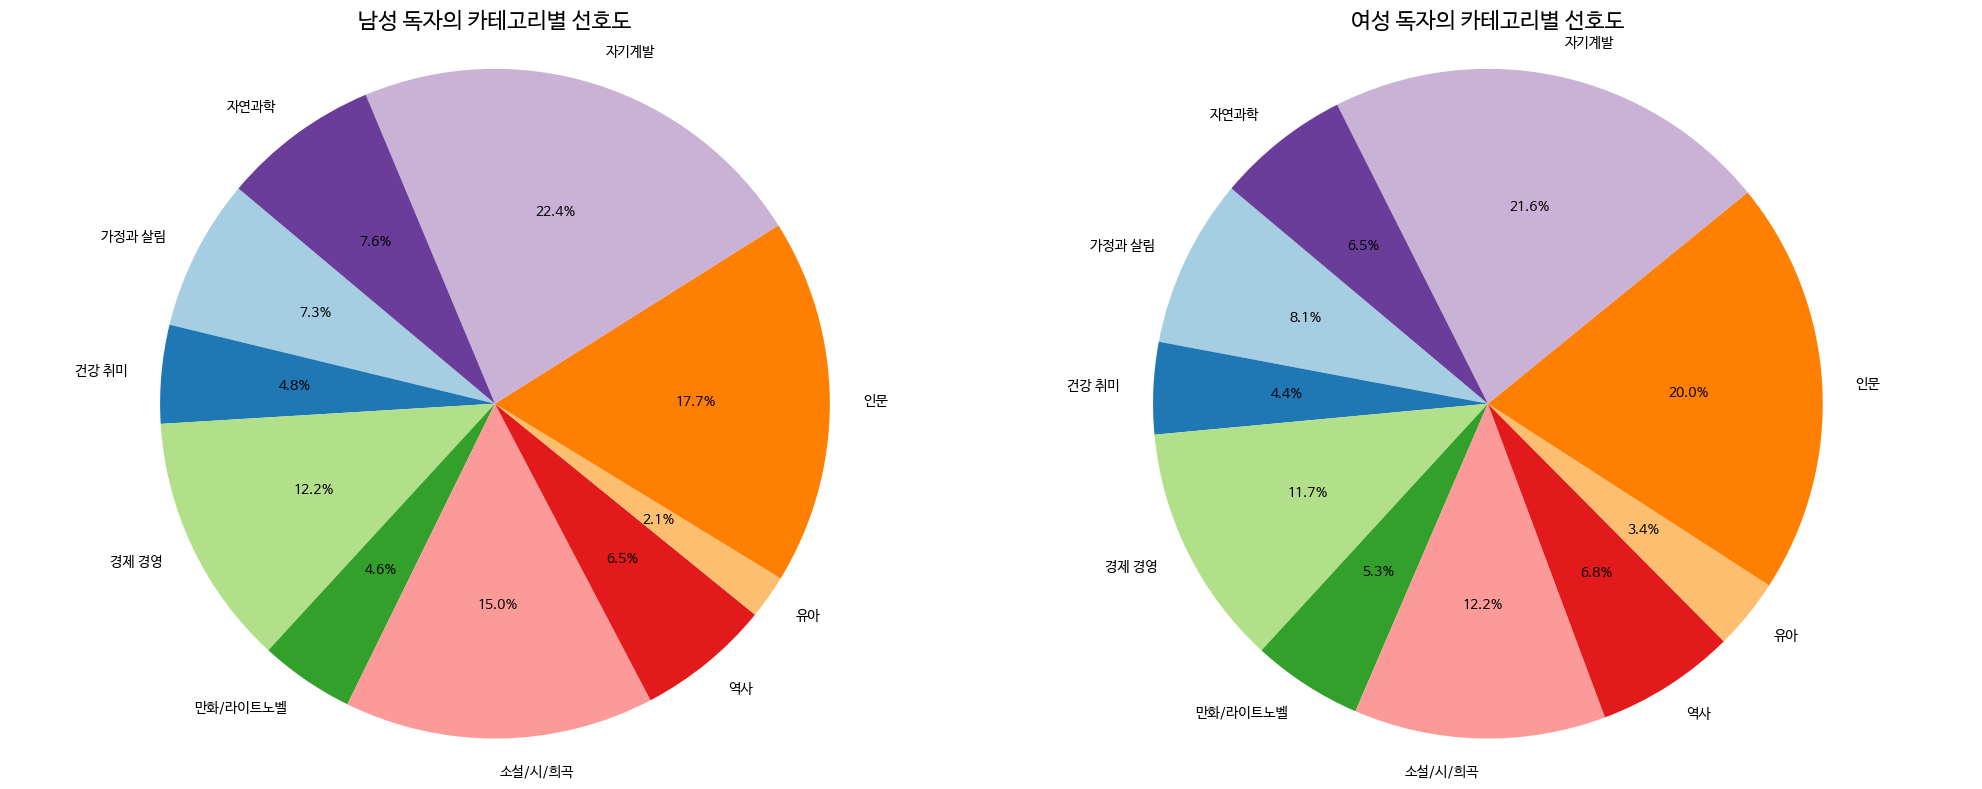

In [71]:
# 성별에 따른 도서 카테고리 선호도 (전체)
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

genders = ['남자', '여자']
titles = ['남성 독자의 카테고리별 선호도', '여성 독자의 카테고리별 선호도']

for i, gender in enumerate(genders):
    data = yes_df[yes_df['Gender'] == gender]
    category_sales_sum = data.groupby('Category')['Sales_Index'].mean()

    top3_categories = category_sales_sum.nlargest(3) # 상위 3개 카테고리만 확인

    ax = axes[i]
    ax.pie(category_sales_sum, labels=category_sales_sum.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
    ax.set_title(titles[i], size=16)
    ax.axis('equal')  # 원형을 유지하기 위해

plt.tight_layout()
plt.show()


# Final Output